## Step 1 — Load the Customer 360 View into Pandas

In [1]:
import sqlite3
import pandas as pd
import numpy as np

In [2]:
conn = sqlite3.connect("./../sql/retail_customer_experience.db")
customer_360_df = pd.read_sql_query("SELECT * FROM customer_360_view;", conn)
customer_360_df.head()

,customer_id,full_name,city,gender,age,preferred_channel,total_transactions,total_spent,avg_transaction_value,last_purchase_date,total_tickets,avg_resolution_time,avg_support_score,total_reviews,avg_rating,last_review_date
0,4c30e132-0704-4459-a509-9eddde934977,Mark Johnson,Houston,Male,40.0,None,3,3565.72,1188.573333,2024-12-17,1,45.0,5.0,0,NaN,None
1,68bec407-275f-4b5b-9a82-13d02f54626a,Robert Smith,Austin,Male,33.0,in-store,9,8925.78,991.753333,2024-09-16,0,NaN,NaN,0,NaN,None
2,4466459f-76c8-433c-814e-6d59cb4131fc,Jamie Chavez,Detroit,Female,42.0,online,4,3820.41,955.102500,2025-02-14,0,NaN,NaN,0,NaN,None
3,04c36a25-02f3-462c-92b0-6bf291c57706,Thomas Bradley,Fort Worth,Male,53.0,both,6,1883.76,376.752000,2024-12-28,1,30.0,5.0,0,NaN,None
4,e916df3d-c3f5-40b0-8ae2-5d043be88300,Jane Ferrell,Atlanta,Female,32.0,online,15,8161.57,582.969286,2024-10-18,0,NaN,NaN,0,NaN,None


## Step 2 — Inspect and Clean

In [3]:
customer_360_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            5000 non-null   object 
 1   full_name              4894 non-null   object 
 2   city                   4903 non-null   object 
 3   gender                 4888 non-null   object 
 4   age                    4814 non-null   float64
 5   preferred_channel      4886 non-null   object 
 6   total_transactions     5000 non-null   int64  
 7   total_spent            4603 non-null   float64
 8   avg_transaction_value  4603 non-null   float64
 9   last_purchase_date     4618 non-null   object 
 10  total_tickets          5000 non-null   int64  
 11  avg_resolution_time    2043 non-null   float64
 12  avg_support_score      2017 non-null   float64
 13  total_reviews          5000 non-null   int64  
 14  avg_rating             830 non-null    float64
 15  last

In [4]:
customer_360_df.describe()

,age,total_transactions,total_spent,avg_transaction_value,total_tickets,avg_resolution_time,avg_support_score,total_reviews,avg_rating
count,4814.000000,5000.000000,4603.000000,4603.000000,5000.000000,2043.000000,2017.000000,5000.00000,830.000000
mean,35.039676,6.459000,6037.767732,909.726944,0.600000,46.263893,3.436614,0.20000,4.032932
std,11.084544,4.844194,6899.228425,1090.540884,0.804816,29.764599,1.121816,0.48913,1.008933
min,18.000000,0.000000,19.280000,19.280000,0.000000,1.000000,1.000000,0.00000,1.000000
25%,27.000000,3.000000,2046.575000,516.358556,0.000000,25.000000,3.000000,0.00000,3.500000
50%,35.000000,6.000000,4549.790000,738.307273,0.000000,41.000000,3.500000,0.00000,4.000000
75%,42.000000,9.000000,8004.650000,1024.058947,1.000000,61.500000,4.000000,0.00000,5.000000
max,80.000000,33.000000,145080.340000,27784.595000,6.000000,240.000000,5.000000,4.00000,5.000000


In [5]:
customer_360_df.isna().sum()

customer_id                 0
full_name                 106
city                       97
gender                    112
age                       186
preferred_channel         114
total_transactions          0
total_spent               397
avg_transaction_value     397
last_purchase_date        382
total_tickets               0
avg_resolution_time      2957
avg_support_score        2983
total_reviews               0
avg_rating               4170
last_review_date         4170
dtype: int64

In [ ]:
# 1. Fill demographic info
customer_360_df['full_name'].fillna('Unknown', inplace=True)
customer_360_df['city'].fillna('Unknown', inplace=True)
customer_360_df['gender'].fillna('Unknown', inplace=True)
customer_360_df['preferred_channel'].fillna('Unknown', inplace=True)

# 2. Handle numeric "activity" columns
activity_cols = [
    'total_spent', 'avg_transaction_value', 'total_tickets',
    'avg_resolution_time', 'avg_support_score',
    'total_reviews', 'avg_rating'
]
customer_360_df[activity_cols] = customer_360_df[activity_cols].fillna(0)


# 3. For dates — keep NaT (it means “no recent activity”)
date_cols = ['last_purchase_date', 'last_review_date']
for col in date_cols:
    customer_360_df[col] = pd.to_datetime(customer_360_df[col], errors='coerce')

# 4. Handle age (could impute with median)
median_age = customer_360_df['age'].median()
customer_360_df['age'].fillna(median_age, inplace=True)

# 5. Add interaction flags
customer_360_df['has_support_history'] = np.where(customer_360_df['avg_support_score'] > 0, 1, 0)
customer_360_df['has_review'] = np.where(customer_360_df['avg_rating'] > 0, 1, 0)
customer_360_df['has_transaction'] = np.where(customer_360_df['total_spent'] > 0, 1, 0)

In [7]:
customer_360_df.isna().sum()

customer_id                 0
full_name                   0
city                        0
gender                      0
age                         0
preferred_channel           0
total_transactions          0
total_spent                 0
avg_transaction_value       0
last_purchase_date        382
total_tickets               0
avg_resolution_time         0
avg_support_score           0
total_reviews               0
avg_rating                  0
last_review_date         4170
has_support_history         0
has_review                  0
has_transaction             0
dtype: int64

#### Compute RFM Features


Recency ->	How recently they purchased	= today - last_purchase_date 
Frequency ->	How often they purchase	= total_transactions
Monetary -> How much they spend	= total_spent

In [8]:
from datetime import datetime

In [9]:
# Define refrence date (most recent date in data)
refrence_date = pd.to_datetime(customer_360_df['last_purchase_date']).max() or pd.Timestamp.today()

# calculate recency (in days)
customer_360_df['recency_days'] = (refrence_date - customer_360_df['last_purchase_date']).dt.days

# replace Nat recencies (no purchase history) with a large value (999)
customer_360_df['recency_days'].fillna(999, inplace=True)

# frequency & monetary are already available
customer_360_df.rename(columns={
    'total_transactions' : 'frequency',
    'total_spent' : 'monetary',
}, inplace=True)

/tmp/ipykernel_3281/1079215808.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_360_df['recency_days'].fillna(999, inplace=True)


In [10]:
customer_360_df['avg_support_score'].describe()

count    5000.000000
mean        1.386330
std         1.830425
min         0.000000
25%         0.000000
50%         0.000000
75%         3.000000
max         5.000000
Name: avg_support_score, dtype: float64

#### Engagement & Satisfaction Metrics

In [11]:
customer_360_df['engagement_score'] = (
    0.4 * (customer_360_df['has_transaction']) + 
    0.3 * (customer_360_df['has_support_history']) + 
    0.3 * (customer_360_df['has_review'])
)

customer_360_df['satisfaction_index'] = (
    0.6 * customer_360_df['avg_support_score'] +
    0.4 * customer_360_df['avg_rating']
)

We can estimate a simple CLV approximation based on transaction value and recency.

In [12]:
customer_360_df['clv_estimate'] = (
    (customer_360_df['monetary'] / (1 + customer_360_df['recency_days'] / 365))
)

####

In [13]:
customer_360_df[['customer_id', 'recency_days', 'frequency', 'monetary', 'engagement_score', 'satisfaction_index', 'clv_estimate']].head()


,customer_id,recency_days,frequency,monetary,engagement_score,satisfaction_index,clv_estimate
0,4c30e132-0704-4459-a509-9eddde934977,70.0,3,3565.72,0.7,3.0,2991.925977
1,68bec407-275f-4b5b-9a82-13d02f54626a,162.0,9,8925.78,0.4,0.0,6181.991841
2,4466459f-76c8-433c-814e-6d59cb4131fc,11.0,4,3820.41,0.4,0.0,3708.642686
3,04c36a25-02f3-462c-92b0-6bf291c57706,59.0,6,1883.76,0.7,3.0,1621.633019
4,e916df3d-c3f5-40b0-8ae2-5d043be88300,130.0,15,8161.57,0.4,0.0,6018.127374


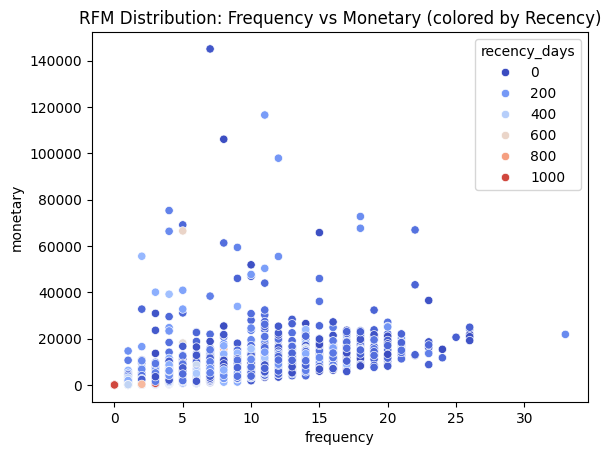

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=customer_360_df, 
    x='frequency', 
    y='monetary', 
    hue='recency_days', 
    palette='coolwarm'
)
plt.title("RFM Distribution: Frequency vs Monetary (colored by Recency)")
plt.show()


## Step 3 — Spending Patterns by City, Gender, and Age Group

<Axes: title={'center': 'Top 10 Cities by total Spend'}, xlabel='city'>

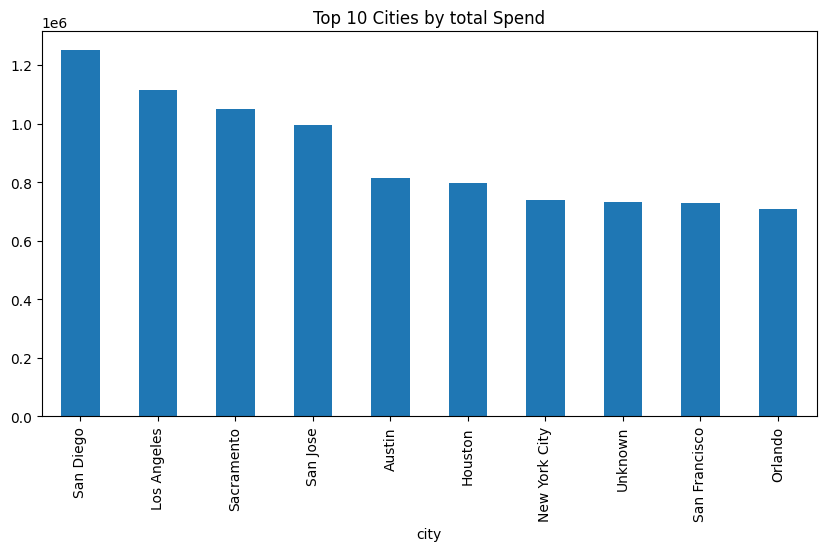

In [15]:
# total spend by city
city_spend = customer_360_df.groupby('city')['monetary'].sum().sort_values(ascending=False).head(10)
city_spend.plot(kind='bar', figsize=(10,5), title='Top 10 Cities by total Spend')

<Axes: title={'center': 'Average Spend by Gender'}, xlabel='gender'>

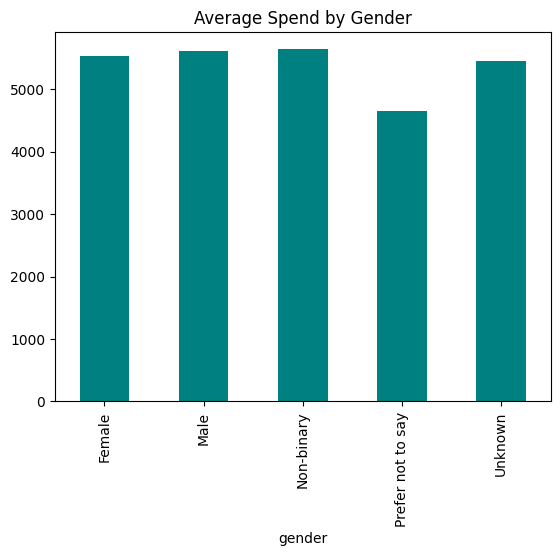

In [16]:
# average spend by gender
gender_spend = customer_360_df.groupby('gender')['monetary'].mean()
gender_spend.plot(kind='bar', color='teal', title='Average Spend by Gender')

In [17]:
customer_360_df.groupby('city')['monetary'].sum()

city
Akron             312065.010000
Albany            554969.204485
Alexandria        217428.005296
Allentown         393651.819978
Ann Arbor         245962.915776
                      ...      
Unknown           733002.884868
Vancouver         159214.291264
Virginia Beach    262861.212669
Winston-Salem     190831.352157
Worcester         193818.447428
Name: monetary, Length: 75, dtype: float64

In [ ]:
# spend by age group
bins = [0, 25, 35, 45, 60, 100]
labels =['18-25', '26-35', '36-45', '46-60', '60+']
customer_360_df['age_group'] = pd.cut(customer_360_df['age'], bins=bins, labels=labels, right=False)

age_spend = customer_360_df.groupby('age_group')['monetary'].mean()
age_spend.plot(kind='bar', color='orange', title= 'Average Spend by Age Group')

## Step 4 — Correlation Between Satisfaction & Spend

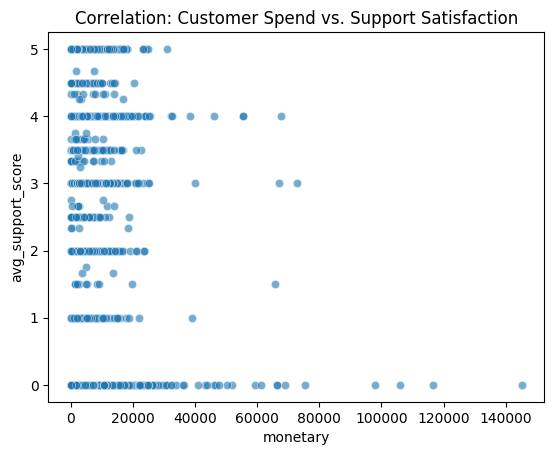

,monetary,avg_support_score
monetary,1.000000,-0.020489
avg_support_score,-0.020489,1.000000


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=customer_360_df, 
    x='monetary', 
    y='avg_support_score', 
    alpha=0.6
)
plt.title("Correlation: Customer Spend vs. Support Satisfaction")
plt.show()

# Correlation coefficient
customer_360_df[['monetary', 'avg_support_score']].corr()


## Step 5 — Support Volume and Resolution Time

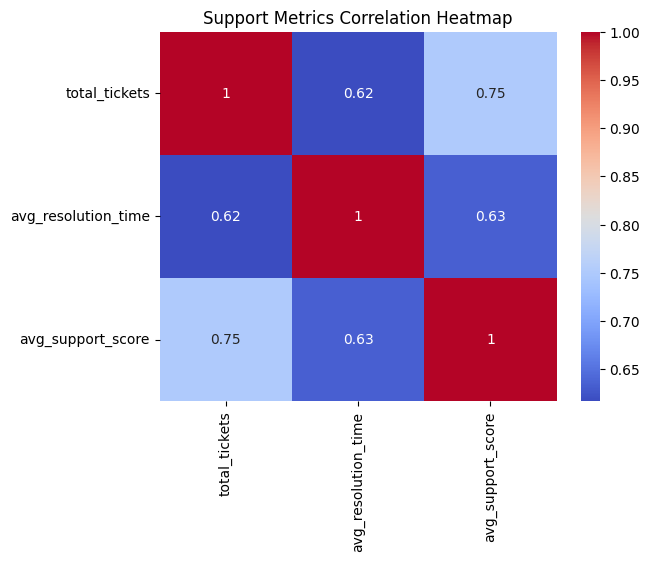

In [27]:
support_stats = customer_360_df[['total_tickets', 'avg_resolution_time','avg_support_score']].describe()


# Visual correlation
sns.heatmap(customer_360_df[['total_tickets', 'avg_resolution_time', 'avg_support_score']].corr(), annot=True, cmap='coolwarm')
plt.title("Support Metrics Correlation Heatmap")
plt.show()


In [29]:
campaigns_df = pd.read_sql_query("SELECT * FROM campaigns;", conn)

# calculate key metrics
campaigns_df['CTR'] = campaigns_df['clicks'] / campaigns_df['impressions']
campaigns_df['CPC'] = campaigns_df['budget'] / campaigns_df['clicks']
campaigns_df['ROI'] = campaigns_df['roi'] 

# Quick insights
campaign_summary = campaigns_df[['campaign_type', 'CTR', 'conversion_rate', 'ROI']].groupby('campaign_type').mean()
campaign_summary.sort_values('ROI', ascending=False)


,CTR,conversion_rate,ROI
campaign_type,,,
Search Engine Marketing,0.053439,9.532105,8560.183684
Email Marketing,0.026966,4.988667,2580.101333
In-Store Promotion,0.005936,29.651053,2431.740500
Social Media,0.012152,2.976154,567.501667
Radio Advertisement,0.006486,3.308261,344.813478
Online Display Ads,0.005120,3.232400,343.220000
Influencer Marketing,0.005106,3.232857,285.981429
TV Advertisement,0.004914,3.221111,214.201765
Print Advertisement,0.005538,3.213636,212.487391


<Axes: title={'center': 'Average ROI by Campaign Type'}, xlabel='campaign_type'>

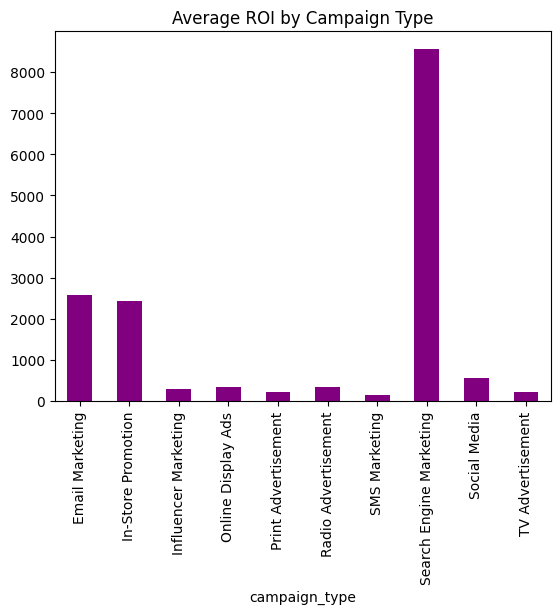

In [31]:
campaign_summary['ROI'].plot(kind='bar', color='purple', title='Average ROI by Campaign Type')


## Step 7 — Product Review Sentiment Distribution

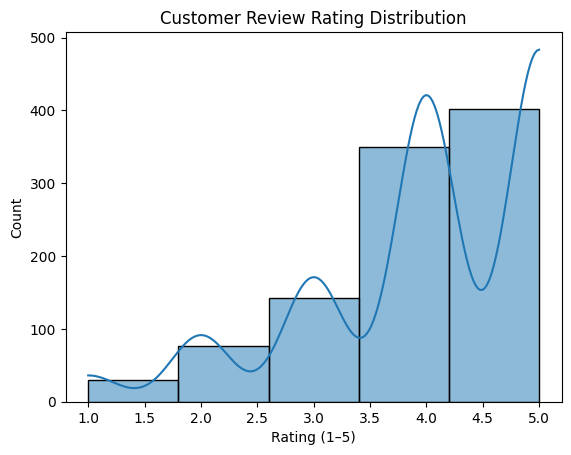

<Axes: title={'center': 'Average Rating by Product Category'}, xlabel='product_category'>

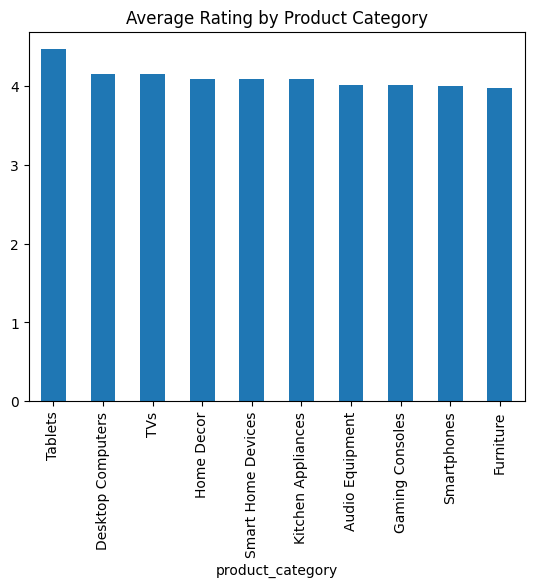

In [35]:
reviews_df = pd.read_sql_query("SELECT * FROM customer_reviews;", conn)

sns.histplot(reviews_df['rating'], bins=5, kde=True)
plt.title("Customer Review Rating Distribution")
plt.xlabel("Rating (1–5)")
plt.ylabel("Count")
plt.show()

# Average rating by product category
avg_rating_by_cat = reviews_df.groupby('product_category')['rating'].mean().sort_values(ascending=False)
avg_rating_by_cat.head(10).plot(kind='bar', title='Average Rating by Product Category')


In [38]:
print("EDA Summary:")
print(f"- Top Spending City: {city_spend.idxmax()} (${city_spend.max():,.0f})")
print(f"- Highest Average Satisfaction: {customer_360_df['avg_support_score'].mean():.2f}")
print(f"- Correlation (Spend vs Satisfaction): {customer_360_df[['monetary', 'avg_support_score']].corr().iloc[0,1]:.2f}")


EDA Summary:
- Top Spending City: San Diego ($1,252,171)
- Highest Average Satisfaction: 1.39
- Correlation (Spend vs Satisfaction): -0.02
